<img src=" 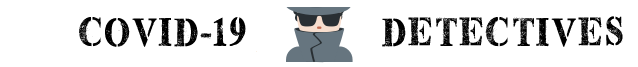">
</img>

In [1]:
from NiG import NiG
import pandas as pd
import numpy as np
import git
import os
import re
from scipy.stats import norm, invgamma, t
import ipywidgets as widgets
from IPython.display import clear_output
import matplotlib.pylab as plt
import plotly.graph_objects as go
%matplotlib inline

# 💾 Obtaining & Preparing the data
We use [this](https://github.com/CSSEGISandData/COVID-19.git) COVID-19 dataset, which contains time series of the confirmed, dead and also recovered cases of COVID-19 in each respective country/province.

For a better comfort we also used Git library to automatically retrieve the most recent data.

In [2]:
if os.path.exists("./COVID-19"):
    print(git.Git("./COVID-19").pull())
else:
    print("Cloning repository..")
    git.Git("./").clone("https://github.com/CSSEGISandData/COVID-19.git")
    print("Done.")

Already up to date.


In [3]:
confirmed = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

After loading the datasets, with help of regular expressions, we extract the date column headers. We use those to aggregate and also work with the datasets. 

In [4]:
regex = re.compile('\d+\/\d+\/\d+') # matches format (d)d\mm\YY
dates = [column for column in confirmed.columns.to_list() if regex.match(column)]

In [5]:
confirmed.head(5)

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  5/1/20  5/2/20  5/3/20  5/4/20  5/5/20  \
0        0        0        0  ...    2335    2469    2704    2894    3224   
1        0        0        0  ...     782     789     795     803     820   
2        0        0        0  ...    4154    4295    4474    4648    4838   
3        0        0        0  ...     745     747     748     750     751   
4        0        0        0  ...      30      35      35      35      36   

   5/6/20  5/7/20  5/8/20  5/9/20  5/10/20  
0    3392    3563    3778    4033     4402  
1     832     842     850     856      868  
2    4997    5182    5369    5558     5723  
3     751     752     752     754      755  
4      36      36      43      43       45  

[5 rows x 114 columns]

Since the records are on level of province we aggregate them by `Country` and sum values of each date in list we prepared earlier.

In [6]:
def aggByCountry(df):
    groups = df.groupby("Country/Region").agg({k:['sum'] for k in dates})
    groups.columns = groups.columns.get_level_values(0)
    return groups

In [7]:
confirmed = aggByCountry(confirmed)
deaths = aggByCountry(deaths)
recovered = aggByCountry(recovered)

Then we extract dataset of currently infected cases, which is basically:

$$ currently\ ill =  confirmed\ cases - (deaths + recovered )$$

In [8]:
currently_ill = confirmed - deaths - recovered

In [9]:
currently_ill.head(5)

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Country/Region                                                                  
Afghanistan           0        0        0        0        0        0        0   
Albania               0        0        0        0        0        0        0   
Algeria               0        0        0        0        0        0        0   
Andorra               0        0        0        0        0        0        0   
Angola                0        0        0        0        0        0        0   

                1/29/20  1/30/20  1/31/20  ...  5/1/20  5/2/20  5/3/20  \
Country/Region                             ...                           
Afghanistan           0        0        0  ...    1957    2066    2274   
Albania               0        0        0  ...     263     239     233   
Algeria               0        0        0  ...    1880    1964    2075   
Andorra               0        0        0  ...     234     231     210   
Angola                0        0        0  ...      17      22      22   

                5/4/20  5/5/20  5/6/20  5/7/20  5/8/20  5/9/20  5/10/20  
Country/Region                                                           
Afghanistan       2407    2708    2830    2989    3197    3416     3724  
Albania            229     219     206     206     199     198      187  
Algeria           2185    2301    2324    2376    2414    2518     2543  
Andorra            206     191     184     179     168     161      157  
Angola              22      23      23      23      30      28       30  

[5 rows x 110 columns]

Since some countries have a long time span without any case, we cropp this 'Zero padding' and use the newly created dataset for some magic.

In [10]:
def cropByInfected(df, country, infected):
    tmp = df[df.index==country].T.copy()
    tmp = tmp[(tmp[country]>=infected)]
    return tmp.T.values[0]

## 🚨🚨 Attention 🚨🚨 
If the checkbox in cell bellow doesn't render properly, run:

`jupyter nbextension enable --py widgetsnbextension`

In [11]:
widgets.Checkbox(
    value=True,
    description='It works!',
    disabled=True,
    indent=False
)

Checkbox(value=True, description='It works!', disabled=True, indent=False)

# 📈 AR model
AR stands for AutoRegressive model. ARs are used commonly use for prediction and analyse on time series.

AR(n) looks like:
$$y_{t}  = \beta_0 + \sum_{k=1}^{n} \beta_k x_{n-k}+\epsilon_t$$

$$\varepsilon_t \sim \mathcal{N}(0, \sigma^2).$$

Once the parameters of autoregression have been estimated, the autoregression can be used to predict few periods into the future.

$$\hat{y_{t}}  = \beta_0 + \beta_1 x_{t-1} + \beta_2 x_{t-2} + ... + \beta_{r-1} x_{t-r-1} $$
**t** is the first unknown period. In the next prediction we will use predicted value from last step as last known value and so on.

We used Student's t distribution as predictive distribution which has variance:
$$var\_t = \frac{2a_{t-1}}{2a_{t-1}-2}*\Sigma_t$$
where $\Sigma$ is scale matrix

$$\Sigma_t = \frac{b_{t-1}}{a_{t-1}}*(1 + x^T_t*V_{t-1}*x_t)$$

In [12]:
def t_mean_var(n, mu, Sigma):
    return [mu, n/(n-2)*Sigma]

In [13]:
def AR(r, data, n=1): #AR(r) model with n future predictions
    point_predictions = [data[i] for i in range(r+1)]
    predictive_var = [0 for i in range(r+1)]
    
    ##Set prior parameters
    xi0 = np.diag([1] + [0.01 for s in range(r)])
    nu0 = r
    lam = 0.999
    prior = NiG(xi0, nu0, lam)
    
    for i in range(r, len(data)): #fitting model with data
        y = data[i]
        x = np.array([1] + [data[i-s] for s in range(1,r)]) #regressor starts with 1 and continues with r-1 old data
        if i != r: #we don't want predictions for first step
            yhat = prior.Ebeta.dot(x) #calculate prediction
            sigma = prior.b / prior.a * (1. + x.dot(prior.V).dot(x)) #scale matrix

            point_predictions.append(yhat) #log prediction
            predictive_var.append(t_mean_var(2*prior.a, yhat, sigma)[1]) #log predictive var

        prior.update(y, x) #bayesian update of model
        prior.log()
    
    #model is now fitted to all available data, it's time for future predictions
    tmp = data[-r+1:] #we take last r data
    for i in range(n):
        x = np.concatenate((np.array([1]),
                           np.flip(tmp[i:]))) #regressor starts with 1 and continues with r-1 old data, from new to old
        yhat = prior.Ebeta.dot(x) #yhat prediction

        sigma = prior.b / prior.a * (1. + x.dot(prior.V).dot(x)) #scale matrix
        tmp = np.append(tmp, [yhat]) #save predicted yhat for future predictions
        
        point_predictions.append(yhat) #log prediction
        predictive_var.append(t_mean_var(2*prior.a, yhat, sigma)[1]+predictive_var[-1]) #log predictive var
        
        prior.update(yhat, x) #update model for future use
        prior.log()
        
    return prior, point_predictions, predictive_var

In [14]:
country_list = []
MAX_SIZE = int(10e50)

In [15]:
country_select = widgets.Dropdown(
    options=confirmed.index.values,
    description='Country:',
    disabled=False,
)

add_country = widgets.Button(
    description='',
    disabled=False,
    button_style='info',
    tooltip='Adds country',
    icon='fa-plus'
)
add_country.layout.width = '30px'


clear_plot = widgets.Button(
    description='',
    disabled=False,
    button_style='danger',
    tooltip='Reset countries',
    icon='trash'
)
clear_plot.layout.width = '30px'



number_of_cases = widgets.BoundedIntText(
    value=10,
    min=0,
    max=MAX_SIZE,
    step=1,
    description='Cases:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

draw_plot = widgets.Button(
    description='Draw plot',
    disabled=False,
    button_style='success',
    tooltip='Draws plot',
    icon='check'
)

kind = widgets.Dropdown(
    options=["confirmed","currently ill","deceased","recovered"],
    description='Kind :',
    disabled=False,
)
selected = widgets.Label(
    value="Selected Countries: []",
)

In [16]:
add = widgets.Box([ country_select , add_country, clear_plot])
actions = widgets.Box([kind, number_of_cases])
menu = widgets.HBox([widgets.VBox([actions, add,  selected]), widgets.VBox([  draw_plot])])
out = widgets.Output()

def clear(b):
    with out:
        out.clear_output(True)
        country_list.clear()
        selected.value = "Selected Countries: " + str(country_list) 

        
def draw(b):
    with out:
        out.clear_output(True)
        
        if not country_list:
            add_entry(b)
        
        df = {
            "confirmed": confirmed,
            "currently ill": currently_ill,
            "deceased": deaths,
            "recovered": recovered
                        
        }[kind.value]
        
        fig = go.Figure()
        for country in country_list:
            fig.add_trace(go.Scatter(y=cropByInfected(df, country, number_of_cases.value),
                    mode='lines+markers',
                    name=country))
        fig.update_layout(title=f'{kind.value.capitalize()} rate comparison after {number_of_cases.value} case(s).',
                   xaxis_title='Day',
                   yaxis_title='Count')

        fig.show()


def add_entry(b):
    if country_select.value not in country_list:
        country_list.append(country_select.value)
        selected.value = "Selected Countries: " + ", ".join(country_list) 
    
clear_plot.on_click(clear)
draw_plot.on_click(draw)
add_country.on_click(add_entry)

<center><h1> 😷 Country Comparison </h1> </center>


In the figure below you can compare the stats of respective countries.

You can select what kind of development you want to see:
- Confirmed cases
- Currently ill
- Deceased
- Recovered


The countries are then aligned by the day each of them hit selected number of cases.

In [17]:
display(menu)
out

Output()

In [20]:
out2 = widgets.Output()
kind2 = widgets.Dropdown(
    options=["confirmed","currenrly ill","dead","recovered"],
    description='Kind :',
    disabled=False,
)
kind2.layout.width = '33%'

country2 = widgets.Dropdown(
    options=confirmed.index.values,
    description='Country:',
    disabled=False,
)
country2.layout.width = '33%'

draw_plot2 = widgets.Button(
    description='Draw plot',
    disabled=False,
    button_style='success',
    tooltip='Draws plot',
    icon='check'
)
draw_plot2.layout.width = '23%'

r = widgets.BoundedIntText(
    value=7,
    min=2,
    step=1,
    max=MAX_SIZE,
    description='R:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    width=1
)
r.layout.width = '33%'

n  = widgets.BoundedIntText(
    value=10,
    min=1,
    max=MAX_SIZE,
    step=1,
    description='N:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
n.layout.width = '33%'

infectedw  = widgets.BoundedIntText(
    value=5,
    min=1,
    max=MAX_SIZE,
    step=1,
    description='Cases:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
infectedw.layout.width = '33%'

param = widgets.Checkbox(
    value=False,
    description='Show β',
    disabled=False,
    indent=False
)
param.layout.width = '10%'

def plot_ar(b):
    with out2:
        out2.clear_output(True)
        
        df = {
            "confirmed": confirmed,
            "currenrly ill": currently_ill,
            "dead": deaths,
            "recovered": recovered
                        
        }[kind2.value]
        
        data = cropByInfected(df, country2.value, infectedw.value)
        nig, point_predictions, predictive_var = AR(r.value, data, n=n.value)
        xlocs = np.arange(len(predictive_var))
        
        fig = go.Figure()


        fig.add_trace(go.Scatter(
            y= point_predictions - 3 * np.sqrt(predictive_var),
            legendgroup="predicted",  
            name="Lower bound",
            mode="lines",
            fill="none",
            showlegend=False,
            marker=dict(color="lightgray", size=10)
        ))
        
        fig.add_trace(go.Scatter(
            y=point_predictions + 3 * np.sqrt(predictive_var),
            legendgroup="predicted",  
            name="Upper bound",
            mode="lines",
            fill="tonexty",
            showlegend=False,
            marker=dict(color="lightgray", size=10)
        ))
        
        fig.add_trace(go.Scatter(
            y=point_predictions,
            legendgroup="predicted",  
            name="Predicted data",
            mode="lines+markers",
            fill="none",
            marker=dict(color="crimson", size=10)
        ))

        fig.add_trace(go.Scatter(
            y=data,
            legendgroup="measured",  
            name="Measured data",
            mode="lines+markers",
            fill="none",
            marker=dict(color='#636efa', size=10)
        ))
        fig.update_layout(title=f'AR({r.value}): {n.value} prediction(s) of {kind2.value} in {country2.value}',
                           xaxis_title=f'Day after {infectedw.value}th infected ',
                           yaxis_title=f'Number of {kind2.value}')

        fig.show()
        
        if param.value:
            fig = go.Figure()
            Ebeta_log = np.array(nig.Ebeta_log)
            var_beta_log = np.array(nig.var_beta_log)
            xlocs = np.arange(len(Ebeta_log))
            
            for i in range(0,r.value):
                fig.add_trace(go.Scatter(
                    y=Ebeta_log[:,i] - 3 * np.sqrt(var_beta_log[:,i]),
                    legendgroup=f"b{i}",  
                    name="Lower bound",
                    mode="lines",
                    fill="tonexty",
                    showlegend=False,
                    marker=dict(color="lightgray")
                ))

                fig.add_trace(go.Scatter(
                    y=Ebeta_log[:,i] + 3 * np.sqrt(var_beta_log[:,i]),
                    legendgroup=f"b{i}",  
                    name="Upper bound",
                    mode="lines",
                    fill="tonexty",
                    showlegend=False,
                    marker=dict(color="lightgray")
                ))

                fig.add_trace(go.Scatter(
                    y=Ebeta_log[:,i],
                    legendgroup=f"b{i}",  
                    name=f"β{i}",
                    mode="lines+markers",
                    fill="none",
                ))

                
                
            fig.update_layout(title=f"AR coefficient progression",
                           xaxis_title=f'Time',
                           yaxis_title=f'Amount')
            fig.show()
        
        
draw_plot2.on_click(plot_ar)
menu2 = widgets.VBox([widgets.HBox([kind2, infectedw, country2]),widgets.HBox([ r, n, param,  draw_plot2])])


<center><h1>😷 Predictions based on measured data</h1> </center>

In the figure below we do N prediction based on measured data.


You can specify following parameters:

- **Cases** - how great, at least, must be the first occurence
- **R** - for AR(R) model
- **N** - number of predictions
- **Country** - Country 
- **Show β** - Whether or not to show β progression
- **What kind to predict**:
        - Confirmed cases
        - Currently ill
        - Deceased
        - Recovered

In [21]:
display(menu2)
out2

Output()